In [ ]:
from pathlib import Path

from experiment import Benchmark, Method, Model

In [ ]:
model = Model.DISCRIMINATIVE_MEAN_FIELD
benchmark = Benchmark.PERMUTED_MNIST
experiment_path = Path(
    "/scratch/shared/beegfs/user/experiments/vcl/custom/results/permuted_mnist/discriminative_mean_field"
)

models = {
    "VCL": (Method.VCL, None, None, [17]),
    "VCL + Coreset (200)": (Method.VCL_RANDOM_CORESET, 200, False, [17]),
    "VCL + Coreset (400)": (Method.VCL_RANDOM_CORESET, 400, False, [17]),
    "VCL + Coreset (1000)": (Method.VCL_RANDOM_CORESET, 1000, False, [17]),
    "VCL + Coreset (2500)": (Method.VCL_RANDOM_CORESET, 2500, False, [17]),
    "VCL + Coreset (5000)": (Method.VCL_RANDOM_CORESET, 5000, False, [17]),
    "Coreset only (200)": (Method.RANDOM_CORESET, 200, True, [17]),
    "Coreset only (400)": (Method.RANDOM_CORESET, 400, True, [17]),
    "Coreset only (1000)": (Method.RANDOM_CORESET, 1000, True, [17]),
    "Coreset only (2500)": (Method.RANDOM_CORESET, 2500, True, [17]),
    "Coreset only (5000)": (Method.RANDOM_CORESET, 5000, True, [17]),
}

accs = {}

In [ ]:
import torch


for (display_name, (method, coreset_size, coreset_balanced, plot_seeds)) in models.items():

    if "coreset" in method:
        assert coreset_size is not None
        method_name = f"{method}_coreset_size={coreset_size}_coreset_balanced={coreset_balanced}"
    else:
        method_name = method

    method_histories = [
        experiment_path / method_name / f"seed={seed}" / "history.pth"
        for seed in plot_seeds
    ]

    matrix = []
    for (seed, path) in zip(plot_seeds, method_histories):
        history = torch.load(path)
        matrix.append(torch.tensor([x.mean() for x in history]))

    matrix = torch.stack(matrix)

    accs[display_name] = matrix

/tmp/ipykernel_2968591/3079047578.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  history = torch.load(path)


In [10]:
accs["VCL + Coreset (200)"]

tensor([[0.9819, 0.9716, 0.9674, 0.9640, 0.9606, 0.9551, 0.9502, 0.9392, 0.9364,
         0.9261]], dtype=torch.float64)

/tmp/ipykernel_2968591/2963871503.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', len(accs))


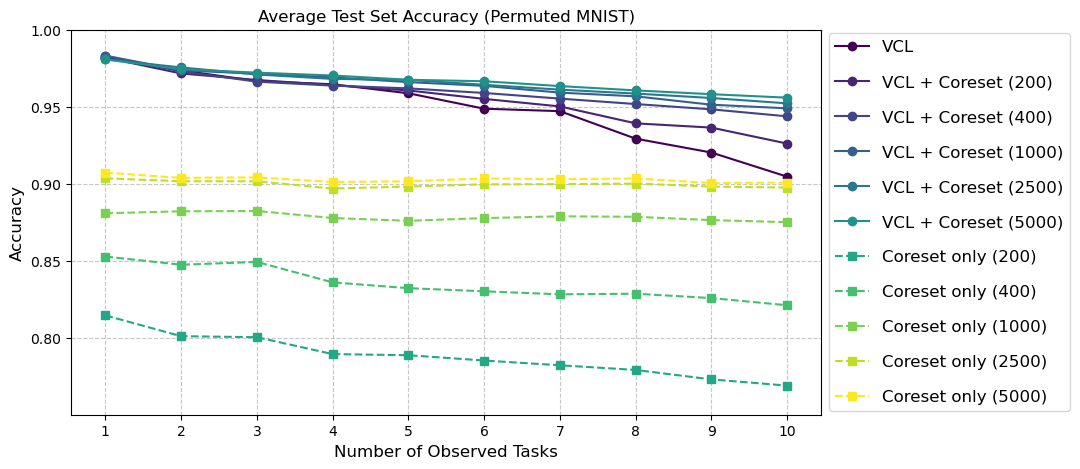

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming accs is a dictionary where each key is a coreset size and the value is a list of accuracy histories
# Increase width while keeping a reasonable height
fig = plt.figure(figsize=(12, 5))

# Get the viridis colormap
viridis = cm.get_cmap('viridis', len(accs))

# Track index for color assignment
for i, (title, hist) in enumerate(accs.items()):
    acc_means = hist.mean(dim=0)

    x = np.arange(1, 11)

    plt.plot(
        x[:len(acc_means)],
        acc_means,
        marker='s' if "only" in title else 'o',  # Square markers
        linestyle='--' if "only" in title else '-',  # Dashed line
        color=viridis(i),  # Use viridis color palette
        label=f'{title}'
    )

# Set x-axis to always show ticks from 1 to 10
plt.xticks(np.arange(1, 11))

# Set y-axis range from 0.8 to 1.0 with ticks at 0.05 increments
plt.ylim(0.75, 1.0)
plt.yticks(np.arange(0.8, 1.05, 0.05))

# Adjust the subplots to make room for the legend
plt.subplots_adjust(right=0.75)

# Add a legend that spans the full height of the plot
plt.legend(
    loc='center left',
    bbox_to_anchor=(1.01, 0.5),
    borderaxespad=0,
    ncol=1,
    bbox_transform=plt.gca().transAxes,
    fontsize=12,
    labelspacing=1.2  # Increase spacing between legend entries
)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels and title with normal font
plt.xlabel('Number of Observed Tasks', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Average Test Set Accuracy (Permuted MNIST)')

# Set a clean, professional font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial',
                                   'DejaVu Sans', 'Helvetica', 'sans-serif']

# Show the plot
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("permuted_mnist_ablation.pdf") as pdf:
    pdf.savefig(fig)  # Pass the figure explicitly
    plt.close(fig)